# **Libraries**

In [118]:
# Import packages:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import tensorflow as tf
import mplfinance as mpf
import plotly.graph_objs as go
import plotly.offline as offline
import math

from functools import reduce
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.keras import callbacks

# **Data** **Frame** 

In [3]:
# Import dataframe from googledrive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file1 = '/content/drive/MyDrive/archive/indexData.csv'
data = pd.read_csv(file1)

file2 = '/content/drive/MyDrive/archive/indexInfo.csv'
info = pd.read_csv(file2)

file3 = '/content/drive/MyDrive/archive/indexProcessed.csv'
processed = pd.read_csv(file3)

In [5]:
info

,Region,Exchange,Index,Currency
0,United States,New York Stock Exchange,NYA,USD
1,United States,NASDAQ,IXIC,USD
2,Hong Kong,Hong Kong Stock Exchange,HSI,HKD
3,China,Shanghai Stock Exchange,000001.SS,CNY
4,Japan,Tokyo Stock Exchange,N225,JPY
5,Europe,Euronext,N100,EUR
6,China,Shenzhen Stock Exchange,399001.SZ,CNY
7,Canada,Toronto Stock Exchange,GSPTSE,CAD
8,India,National Stock Exchange of India,NSEI,INR
9,Germany,Frankfurt Stock Exchange,GDAXI,EUR


In [6]:
data

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0
...,...,...,...,...,...,...,...,...
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0


In [7]:
processed

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...,...
104219,J203.JO,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,J203.JO,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,J203.JO,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,J203.JO,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


# **EDA**

In [8]:
# Check missing value:
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    percent = round(percent,2)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print( missing_df.head(20))
    return None

print("data_M:")
get_missing_data(data)
print("processed_M:")
get_missing_data(processed)

data_M:
           Total  Percent
Volume      2204     1.96
Adj Close   2204     1.96
Close       2204     1.96
Low         2204     1.96
High        2204     1.96
Open        2204     1.96
Date           0     0.00
Index          0     0.00
processed_M:
           Total  Percent
CloseUSD       0      0.0
Volume         0      0.0
Adj Close      0      0.0
Close          0      0.0
Low            0      0.0
High           0      0.0
Open           0      0.0
Date           0      0.0
Index          0      0.0


In [9]:
data["Index"].value_counts()

N225         14500
NYA          13948
IXIC         12690
GSPTSE       10776
HSI           8750
GDAXI         8606
SSMI          7830
KS11          6181
TWII          6010
000001.SS     5963
399001.SZ     5928
N100          5507
NSEI          3381
J203.JO       2387
Name: Index, dtype: int64

In [10]:
processed["Index"].value_counts()

NYA          13947
N225         13874
IXIC         12690
GSPTSE       10526
HSI           8492
GDAXI         8438
SSMI          7671
TWII          5869
000001.SS     5791
399001.SZ     5760
N100          5474
NSEI          3346
J203.JO       2346
Name: Index, dtype: int64

In [11]:
# Window selecting (NYA: 2000-2020):
NYA = data[data.Index == 'NYA']
NYA["Date"] = pd.to_datetime(NYA["Date"])
winNYA = NYA[NYA["Date"].between('2000-01-01', '2020-12-31')]
winNYA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Index,Date,Open,High,Low,Close,Adj Close,Volume
8562,NYA,2000-01-03,6762.109863,6762.109863,6762.109863,6762.109863,6762.109863,0.000000e+00
8563,NYA,2000-01-04,6543.759766,6543.759766,6543.759766,6543.759766,6543.759766,0.000000e+00
8564,NYA,2000-01-05,6567.029785,6567.029785,6567.029785,6567.029785,6567.029785,0.000000e+00
8565,NYA,2000-01-06,6635.439941,6635.439941,6635.439941,6635.439941,6635.439941,0.000000e+00
8566,NYA,2000-01-07,6792.669922,6792.669922,6792.669922,6792.669922,6792.669922,0.000000e+00
...,...,...,...,...,...,...,...,...
13841,NYA,2020-12-24,14398.620120,14398.620120,14324.769530,14382.500000,14382.500000,1.885090e+09
13842,NYA,2020-12-28,14476.349610,14481.480470,14396.230470,14405.769530,14405.769530,3.527460e+09
13843,NYA,2020-12-29,14500.030270,14515.809570,14371.870120,14397.919920,14397.919920,3.387030e+09
13844,NYA,2020-12-30,14447.959960,14520.570310,14447.959960,14477.480470,14477.480470,3.145200e+09


In [12]:
# Double check missing value:
print("winNYA_M:")
get_missing_data(winNYA)

winNYA_M:
           Total  Percent
Volume         0      0.0
Adj Close      0      0.0
Close          0      0.0
Low            0      0.0
High           0      0.0
Open           0      0.0
Date           0      0.0
Index          0      0.0


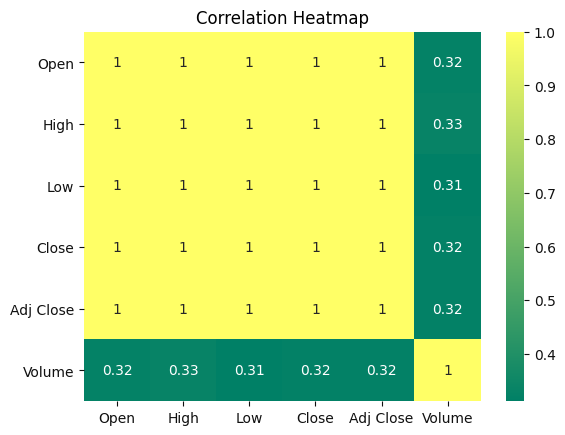

In [21]:
# Correlation Heatmap:
correlations = winNYA.corr()
sns.heatmap(correlations, cmap='summer', annot = True)
plt.title('Correlation Heatmap');

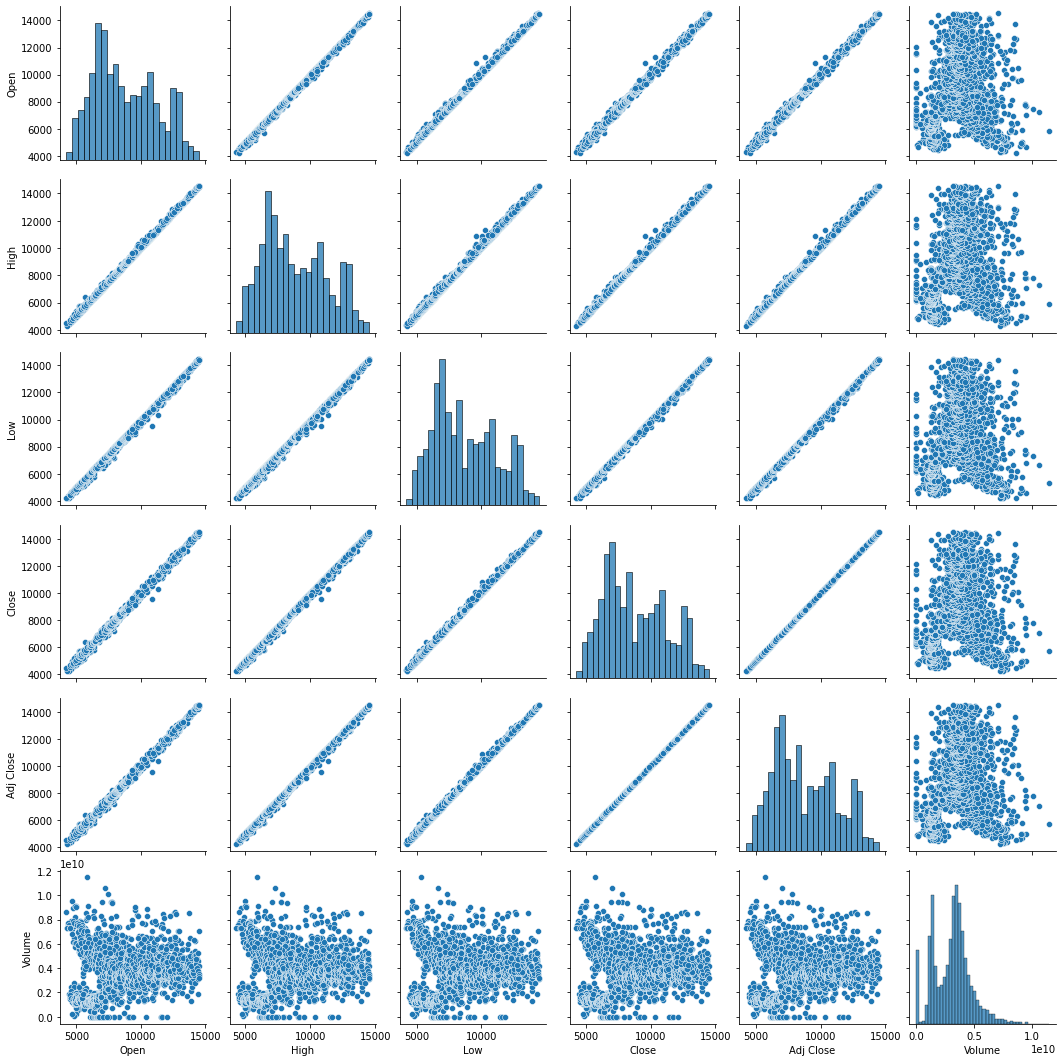

In [15]:
# Correlation Pairmap:
sns.pairplot(winNYA)

/usr/local/lib/python3.7/dist-packages/mplfinance/_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


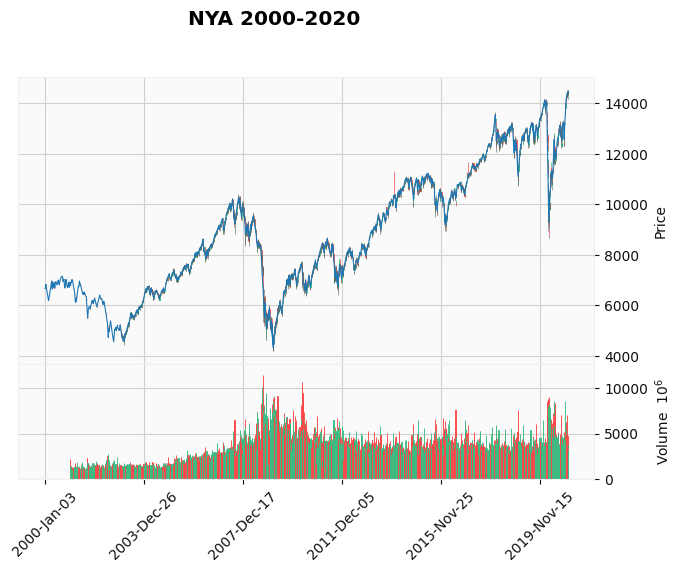

In [17]:
# Candle chart:
setwinNYA = winNYA.set_index('Date')
mpf.plot(setwinNYA, type='candle', mav=(5), volume=True, title='NYA 2000-2020', style='yahoo')

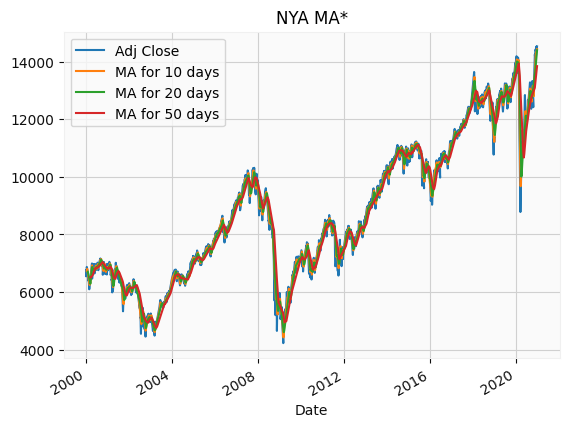

In [18]:
# Moving average:
NYA_adj = winNYA[['Date','Adj Close']]
NYA_adj = pd.DataFrame(NYA_adj)

ma_day = [10, 20, 50]

for ma in ma_day:
      column_name = f"MA for {ma} days"
      NYA_adj[column_name] = NYA_adj['Adj Close'].rolling(ma).mean()

NYA_adj.plot(x = 'Date', y = ['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days'])
plt.title('NYA MA*')
plt.show()

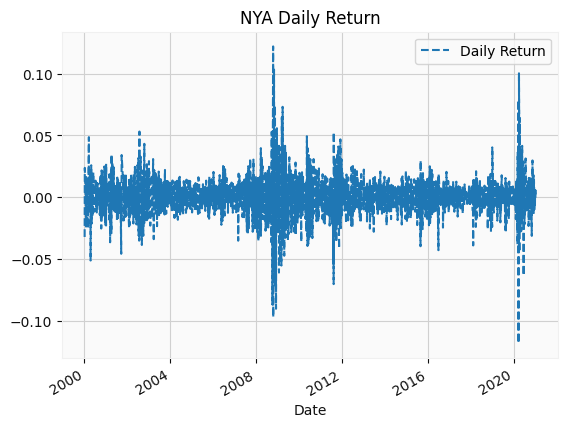

In [19]:
# Daily Return(Percent change):
NYA_adj['Daily Return'] = NYA_adj['Adj Close'].pct_change()

NYA_adj.plot(x = 'Date', y = 'Daily Return', legend=True, linestyle='--')
plt.title('NYA Daily Return')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


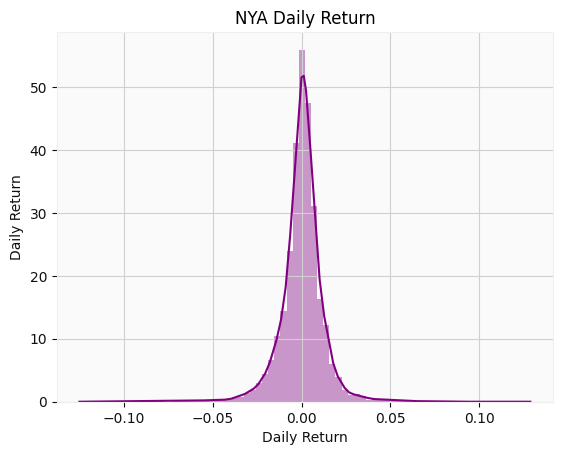

In [20]:
company = NYA_adj['Daily Return']
sns.distplot(company.dropna(), bins=70, color='purple')
plt.ylabel('Daily Return')
plt.title('NYA Daily Return')
plt.show()

# **LSTM**

## *Data preprocessing*

In [96]:
# Select data window:
NYAA = processed[processed.Index == 'NYA']
NYAA["Date"] = pd.to_datetime(NYAA["Date"])
NYAA = NYAA[NYAA["Date"].between('2000-01-01', '2020-12-31')]
preNYA = winNYAA[['Date','CloseUSD']]
preNYA = pd.DataFrame(preNYA)
preNYA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,CloseUSD
17053,2000-01-03,6762.109863
17054,2000-01-04,6543.759766
17055,2000-01-05,6567.029785
17056,2000-01-06,6635.439941
17057,2000-01-07,6792.669922
...,...,...
22332,2020-12-24,14382.500000
22333,2020-12-28,14405.769530
22334,2020-12-29,14397.919920
22335,2020-12-30,14477.480470


In [98]:
# Reshape:
dataset = preNYA.iloc[:,1].values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(5284, 1)

In [99]:
# Scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [100]:
# Train & Test split
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 3963, test size: 1321 


In [101]:
time_stemp = 10
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY) 
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## 1 - Vanilla LSTM

In [102]:
# Model1:
model1 = Sequential()
model1.add(LSTM(10, input_shape=(1, time_stemp)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
3952/3952 [==============================] - 8s 2ms/step - loss: 6.0930e-04
Epoch 2/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.8311e-04
Epoch 3/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.6250e-04
Epoch 4/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.4091e-04
Epoch 5/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.3540e-04
Epoch 6/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.2622e-04
Epoch 7/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.2985e-04
Epoch 8/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.1797e-04
Epoch 9/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.1785e-04
Epoch 10/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.1752e-04
Epoch 11/50
3952/3952 [==============================] - 7s 2ms/step - loss: 1.1145e-04
Epoch 12/50
3952/3952 [==================

In [103]:
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_vanilla = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore_vanilla))

Train Score: 94.56 RMSE
Test Score: 280.18 RMSE


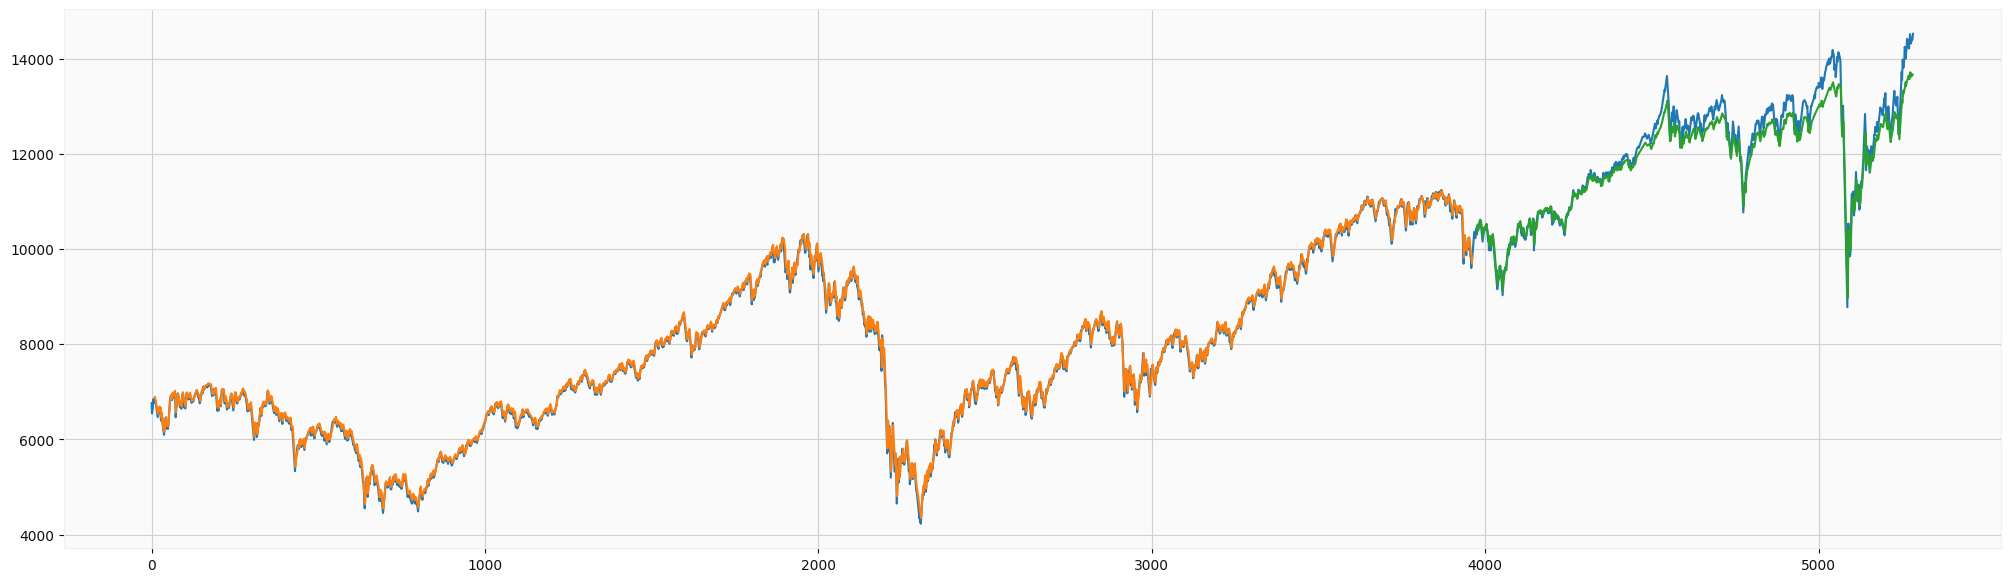

In [106]:
# Shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# Shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
f,ax = plt.subplots(figsize = (25,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 2 - Stacked LSTM

In [107]:
# Re-preprocessing:
dataset = preNYA.iloc[:,1].values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

time_stemp = 10
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY) 
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [108]:
# Model2:
model2 = Sequential()
model2.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1,time_stemp)))
model2.add(LSTM(50, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
3952/3952 [==============================] - 12s 3ms/step - loss: 0.0021
Epoch 2/50
3952/3952 [==============================] - 10s 3ms/step - loss: 2.2449e-04
Epoch 3/50
3952/3952 [==============================] - 10s 3ms/step - loss: 1.9247e-04
Epoch 4/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.7682e-04
Epoch 5/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.6346e-04
Epoch 6/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.6006e-04
Epoch 7/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.5289e-04
Epoch 8/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.4884e-04
Epoch 9/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.4032e-04
Epoch 10/50
3952/3952 [==============================] - 10s 2ms/step - loss: 1.3611e-04
Epoch 11/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.3216e-04
Epoch 12/50
3952/3952 [=============

In [109]:
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_Stacked = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore_Stacked))

Train Score: 105.59 RMSE
Test Score: 268.90 RMSE


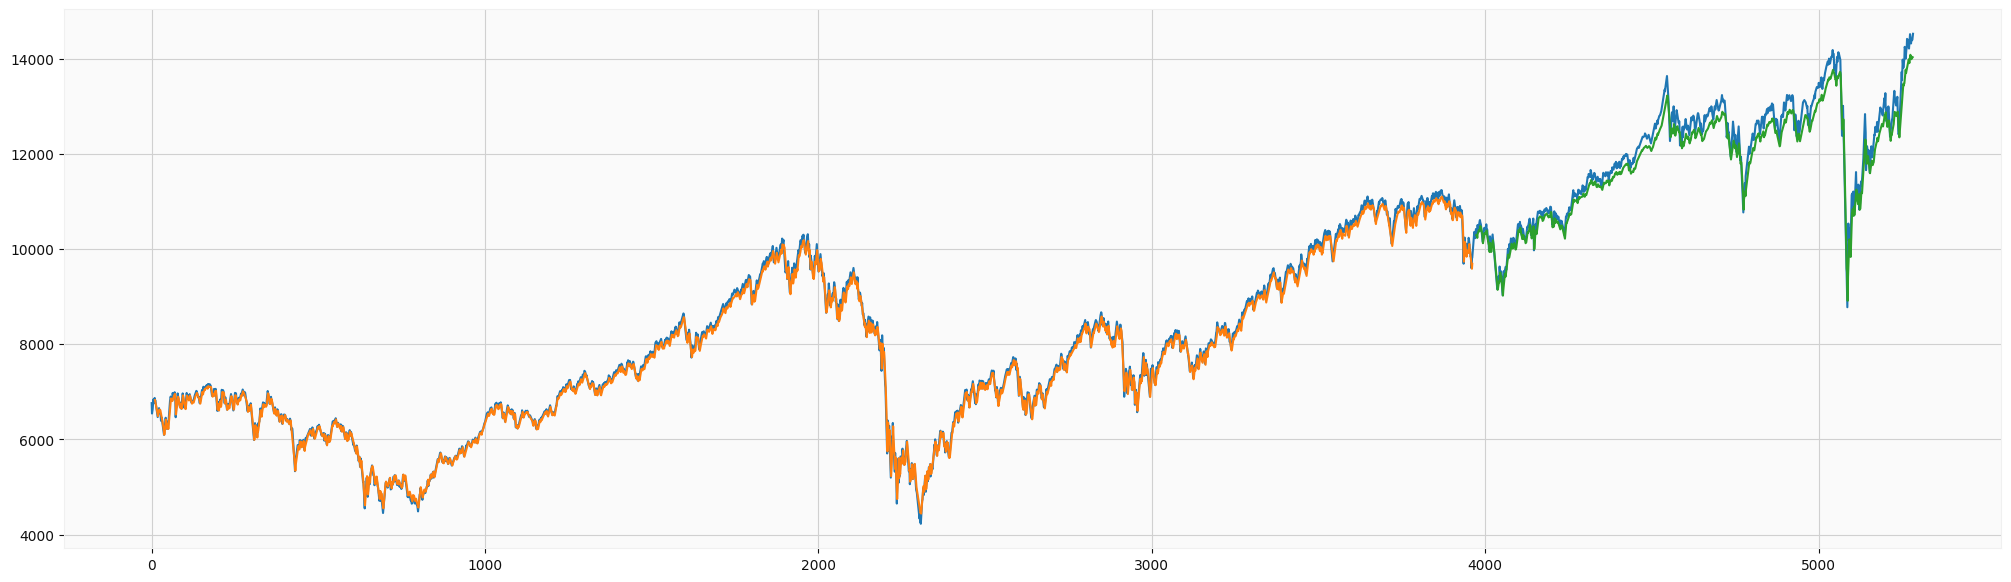

In [110]:
# Shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# Shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
f,ax = plt.subplots(figsize = (25,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 3 - Bidirectional LSTM

In [114]:
# Re-preprocessing:
dataset = preNYA.iloc[:,1].values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

time_stemp = 10
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY) 
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [115]:
# Model3:
model3 = Sequential()
model3.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1,time_stemp)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')
model3.fit(trainX, trainY, epochs=50, batch_size=1)

Epoch 1/50
3952/3952 [==============================] - 11s 2ms/step - loss: 0.0012
Epoch 2/50
3952/3952 [==============================] - 9s 2ms/step - loss: 2.0689e-04
Epoch 3/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.7607e-04
Epoch 4/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.5507e-04
Epoch 5/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.4291e-04
Epoch 6/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.4394e-04
Epoch 7/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.3076e-04
Epoch 8/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.3331e-04
Epoch 9/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.2632e-04
Epoch 10/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.2478e-04
Epoch 11/50
3952/3952 [==============================] - 9s 2ms/step - loss: 1.2279e-04
Epoch 12/50
3952/3952 [=====================

In [116]:
trainPredict = model3.predict(trainX)
testPredict = model3.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_Stacked = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore_Stacked))

Train Score: 105.09 RMSE
Test Score: 198.19 RMSE


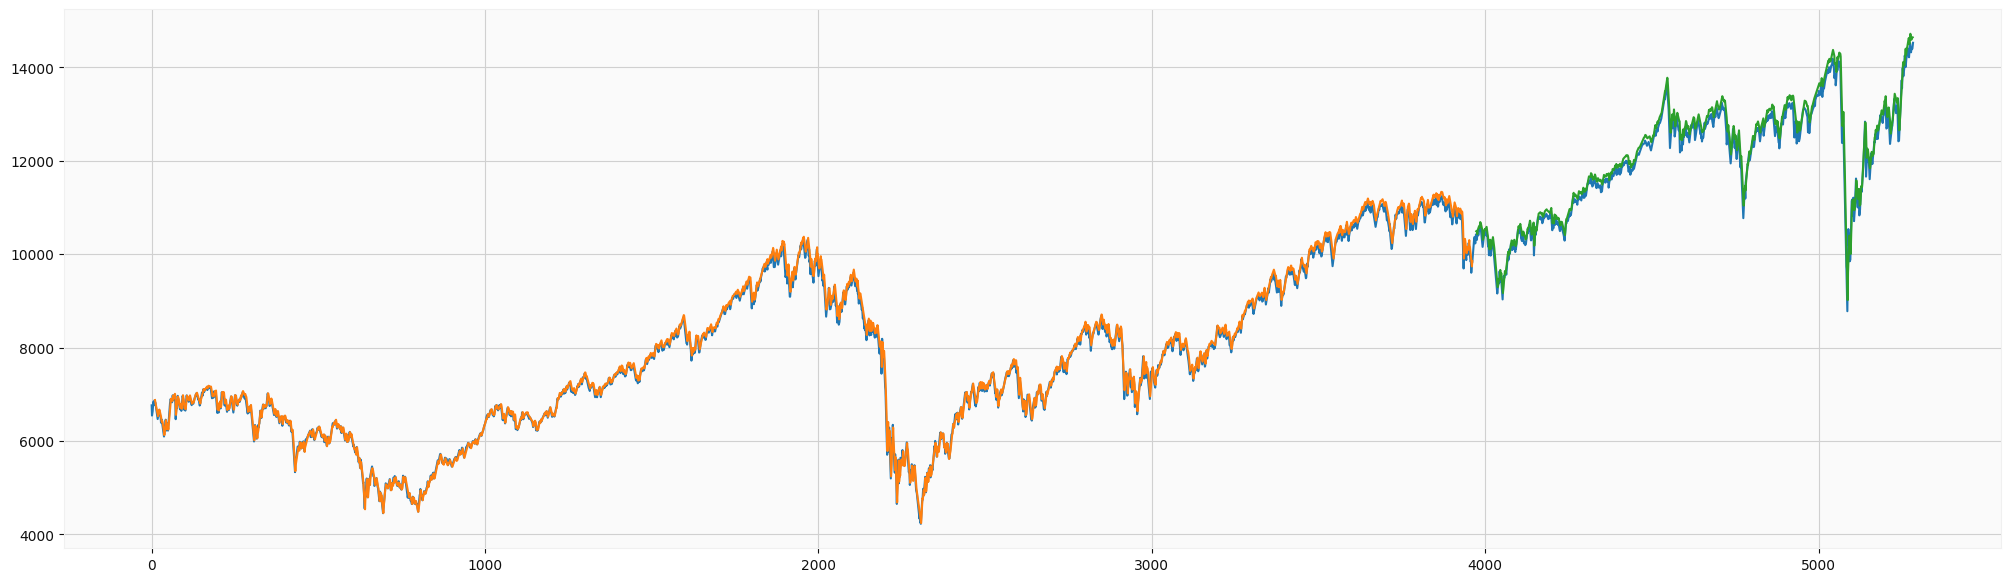

In [117]:
# Shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# Shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
f,ax = plt.subplots(figsize = (25,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## 4 - CNN LSTM

In [122]:
# Re-preprocessing:
dataset = preNYA.iloc[:,1].values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]

time_stemp = 10
dataX = []
dataY = []
for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)
dataX = []
dataY = []
for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])
testX = np.array(dataX)
testY = np.array(dataY) 
trainX = np.reshape(trainX, (trainX.shape[0], 1,1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1,1, testX.shape[1]))

In [123]:
# Model4:
model4 = Sequential()
model4.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,1, time_stemp)))
model4.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model4.add(TimeDistributed(Flatten()))
model4.add(LSTM(50, activation='relu'))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')
model4.fit(trainX, trainY, epochs=50,batch_size=1)

Epoch 1/50
3952/3952 [==============================] - 9s 2ms/step - loss: 8.1484e-04
Epoch 2/50
3952/3952 [==============================] - 8s 2ms/step - loss: 2.1926e-04
Epoch 3/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.9297e-04
Epoch 4/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.8455e-04
Epoch 5/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.6903e-04
Epoch 6/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.5423e-04
Epoch 7/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.5103e-04
Epoch 8/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.4898e-04
Epoch 9/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.4051e-04
Epoch 10/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.4139e-04
Epoch 11/50
3952/3952 [==============================] - 8s 2ms/step - loss: 1.3328e-04
Epoch 12/50
3952/3952 [==================

In [124]:
trainPredict = model4.predict(trainX)
testPredict = model4.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_Stacked = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore_Stacked))

Train Score: 116.96 RMSE
Test Score: 168.88 RMSE


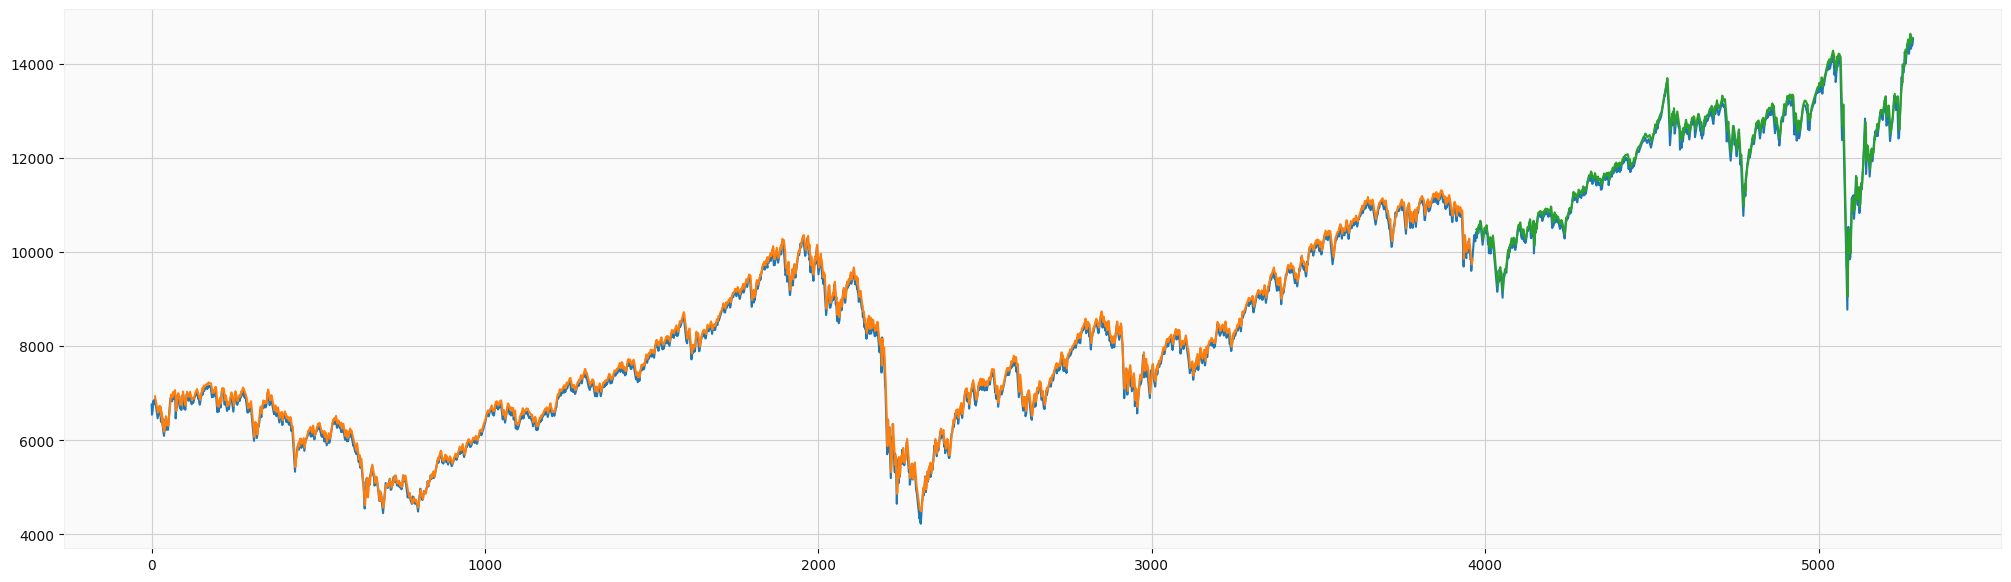

In [125]:
# Shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# Shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# Plot baseline and predictions
f,ax = plt.subplots(figsize = (25,7))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()